# Column Generation - Cutting Stock Example

### Master Problem
Given set of configurations $\Omega = \{1,2,...,n\}$ which dictate how many of each shelf to cut from a single board, select the optimal number of each configuration, $x_i$, to minimize the number of boards used. Ie

Minimize $\sum_i x_i = (1,1,...,1) \cdot (x_1,x_2,...,x_n)^T$

Subject to $\sum_c C_{cs} x_c \geq d_s \iff C^T \cdot (x_1,x_2,...,x_n)^T \geq (d_1,d_2,...,d_n)^T $

Where $C_{cs} = \text{number of times shelf s in config c else 0}$  

```
Minimize sum(x)
Subject to C @ x >= d
C has a column for each configuration, ie C_cs = number of times config c contains shelf s
d is column of demand for each shelf
x is column of number of times each config is used
```


So the s constraints (one for each shelf) are captured in $C_{sc}$. Each constraint produces a dual which is what is used in the objective in the subproblem. The goal of the subproblem is to produce a new configuration (so a new decision variable $x_{n+1}$) with a low reduced cost, which means that it will be selected in the simplex algorithm to join the basis and push the objective down.

### Subproblem
```
Minimize [constraint.Pi for constraint in master problem] @ [n_shelf1, n_shelf2, ...].T
Subject to [width_shelf1, width_shelf2, ....] @ [n_shelf1, n_shelf2, ...] <= Material Width
```

So the optimized ```[n_shelf1, nshelf_2,...]``` is the new configuration to add to our master problem
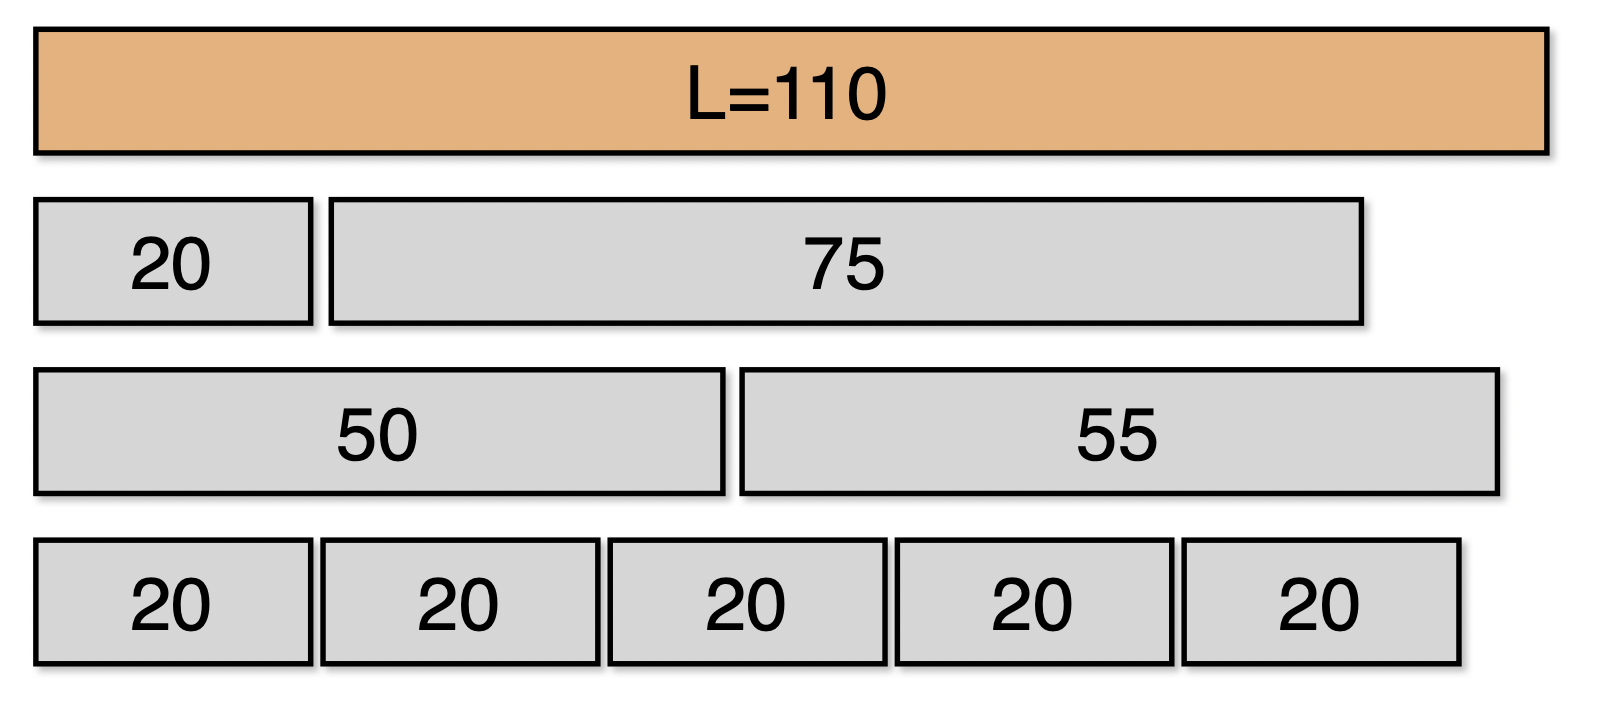

In [2]:
import pandas as pd
import numpy as np
from pulp import *


## https://www.lindo.com/doc/online_help/lingo18_0/cutting_stock_the_details.htm
## sol 985
B = 45  
w = [34,24,15,10,18]
q = [350,100,800,1001,377]


## discrete optimization coursera
## sol 47
# B = 110
# w = [20,45,50,55,75]
# q = [48,35,24,10,8]

def flatten(l):
    return [item for sublist in l for item in sublist]

def greedy_initial_configurations(B,w,q, trivial_sol=True):   
    ## return trivial config found by getting as many of each shelf per board we can
    if trivial_sol:
        return np.diag([B//wi for wi in w]), sum([(B//wi)*qi for wi,qi in zip(w,q)])
    ## return configurations generated by greedy solution that grabs until can't fit
    ## input is size of wood, width of shelves, demand for each
    ## output is tuple
    ## np.array that is [ config as column, config as col, ... ]
    ## objective
    total_shelves = len(w)
    
    shelf_list = flatten(
        sorted(
        [[w]*q 
         for w,q in zip(w,q)],
        reverse=True)
    )
    ## fix this
    idx_map = {wi:idx for idx,wi in enumerate(w)}
    idx_list = [idx_map[wi] for wi in shelf_list]


    config_list = []
    while shelf_list:
        total_w = 0
        config = []
        while total_w < B and shelf_list:
            if total_w + shelf_list[0] <= B:
                config.append(idx_list.pop(0))
                total_w += shelf_list.pop(0)
            else:
                break

        config_list.append(
            [config.count(i) for i in range(total_shelves)]
        )
                
    return np.unique(np.array(config_list),axis=0).T, np.array(config_list).shape[0]



def solve_master(config_cols, linear_relaxation=True):
    ## for a given set of configurations, solve the LP choosing the number of times each configuration should be chosen
    ## configuration is essentially a column defining how many cuts of each type to make in a board ie 3 shelf1, 0 shelf 2, ....
    ## satisfying widthshelf1 * nshelf1 + widthshelf2 * nshelf2 + ..... <= length of board
    problem = LpProblem('cutting_stock', LpMinimize)
    decision_vars = [
        LpVariable(f'x_{i}',lowBound=0, cat='Continuous' if linear_relaxation else 'Integer') 
        for i in range(config_cols.shape[1])
    ]
    ## objective
    problem += np.array([1]*config_cols.shape[1]) @ decision_vars
    ## build constraints then add to model
    constraints = []
    for idx, constraint_lhs in enumerate(config_cols @ decision_vars):
        constraints.append(
            constraint_lhs >= q[idx]
        )
    for idx, constraint in enumerate(constraints):
        problem += constraint ,f'demand {idx}'  
    problem.solve(PULP_CBC_CMD(msg=False))
    ## get reduced costs, as they become c [minimize c.x] of subproblem 
    reduced_costs = [c.pi for c in constraints]    
    return problem.objective.value(), np.array(reduced_costs), np.array([x.value() for x in decision_vars])

def subproblem(reduced_costs, B, w, q):
    ## minimize reduced costs. config st config is feasible
    ## minimize Pi.x subject to w.x <= B
    subproblem = LpProblem('Knapsack', LpMinimize)
    
    ## decision vars
    x = [LpVariable(f'x_{i}',lowBound=0, upBound=None, cat=LpInteger) for i in range(len(w))]
    ## objective
    subproblem += 1 - np.array(reduced_costs) @ np.array(x)
    ## constraint
    subproblem += np.array(w) @ np.array(x) <= B
    ## solve
    subproblem.solve(PULP_CBC_CMD(msg=False))
    # print(subproblem.objective.value())
    # print([xi.value() for xi in x])

    return np.array([int(xi.value()) for xi in x])


def full_problem(B,w,q):
    print(f"material widths:{B}\nwidths:     {w},\nquantities: {q}\n\n")
    config_cols, obj = greedy_initial_configurations(B,w,q)
    print(f'solution to integer problem via greedy algorith: {obj}')
    # print(config_cols)
    num_configs = config_cols.shape[1]
    print('\nsolving linear relaxation')
    new_config_col = True
    count = 0

    while new_config_col and count < 1000:
        obj, reduced_costs, values = solve_master(config_cols)
        print(obj)
        new_config = np.array([subproblem(reduced_costs, B,w,q)]).T ## append generated column
        config_cols = np.unique(np.hstack([config_cols,new_config]),axis=1)
        new_config_col = config_cols.shape[1] > num_configs
        num_configs = config_cols.shape[1]
        count += 1
        
    print()

    print('Now need integer values.')
    obj, reduced_costs, values = solve_master(config_cols, linear_relaxation=False)
    print(f'Minimum number of boards {int(obj)}')
    print()
    return obj, np.array(values), config_cols

obj, values, config_cols = full_problem(B,w,q)
df = (
    pd.DataFrame(
        config_cols.T[values>0],
        columns=w,
        index=values[values>0]
    )
)

df.index.name = 'Frequency'
df.columns.name = 'Widths'
display(df.style.set_caption("Solution").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('font-size', '22px')
    ]
}]))
print()
print(f"extra items {config_cols @ values - np.array(q)}")
print(f"leftover material {np.dot(values,B - config_cols.T @ np.array(w)) / obj/B * 100} %")
print(f"constraint satisfied {(config_cols.T @ np.array(w) <= B).all()}")

material widths:45
widths:     [34, 24, 15, 10, 18],
quantities: [350, 100, 800, 1001, 377]


solution to integer problem via greedy algorith: 7608

solving linear relaxation
1155.41667
1105.41667
1017.9166700000001
994.8333299999999
984.44445

Now need integer values.
Minimum number of boards 985



Widths,34,24,15,10,18
Frequency,,,,,
277.000000,0,0,1,1,1
125.000000,0,0,1,3,0
133.000000,0,0,3,0,0
100.000000,0,1,0,0,1
350.000000,1,0,0,1,0



extra items [0. 0. 1. 1. 0.]
leftover material 2.7163000564015793 %
constraint satisfied True
